In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [2]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [4]:
df = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/nukagvilia/tweets_df3_org')

In [5]:
df2 = df

In [6]:
original_df = df2.filter(df2.retweeted_status.isNull())

In [7]:
df_news = original_df.filter(original_df.organization == 'News')

In [8]:
df_text_raw = df_news.select(["text"])

In [9]:
text = df_text_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [10]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])

In [11]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())

In [12]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [13]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

In [14]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()

In [15]:
jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [16]:
df_dups_30 = df_dups_text

In [ ]:
df_dups_text.cache()

distCol,id_A,id_B,text_A,text_B
0.2222222222222222,11789,176616,[Texas Medical Bo...,[Medical board ta...
0.0,32736,38787,[Australia's #COV...,[Australia's COVI...
0.0,32636,154793,[Influential gove...,[Influential gove...
0.0,7249,154793,[Influential gove...,[Influential gove...
0.16666666666666663,35016,130544,[For Britain's ch...,[For Britain's ch...
0.0,2583,94023,[Weeks away from ...,[Weeks away from ...
0.0,58589,58639,[FDA commissioner...,[FDA commissioner...
0.0,118199,118280,[[JUST IN] Covid-...,[[JUST IN] Covid-...
0.2857142857142857,169843,176795,[Covid Global Dea...,[COVID-19′s globa...
0.2857142857142857,169843,172037,[Covid Global Dea...,[COVID-19's globa...


In [18]:
records = df_hashed_text.count()

In [19]:
dups = df_dups_text.select('id_A').distinct().count()

In [20]:
uniques = records - dups

In [21]:
dups = dups/records * 100 

In [23]:
uniques = uniques/records * 100

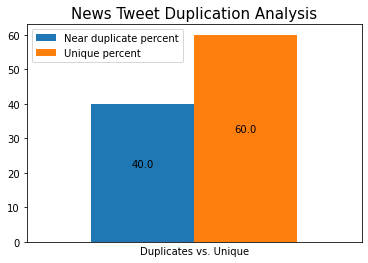

In [24]:
dups_df = pd.DataFrame.from_dict({'Near duplicate percent': [dups], 'Unique percent': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['Near duplicate percent', 'Unique percent'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News Tweet Duplication Analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
       ax.set_xticks([])